In [2]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

In [3]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

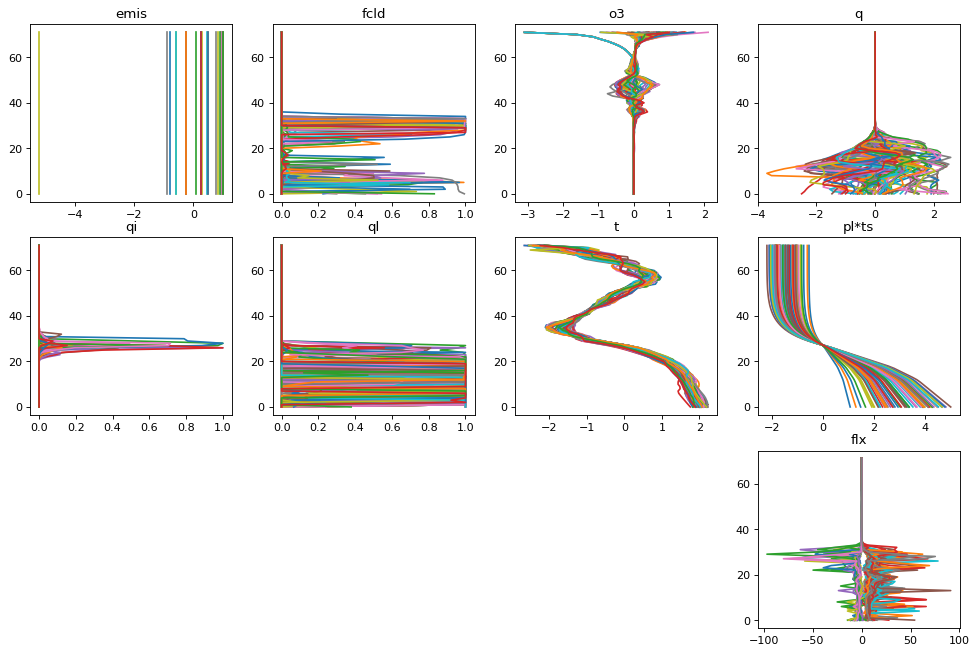

In [3]:
x,y=train_generator[0]
Plot_Batch(x,y,header_x)

In [4]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

list_of_filters_ae = [ [64, 128, 128],
                      [50, 50, 75, 75, 100, 100],
                      [20, 20],
                      [50, 50, 100, 100, 200,200],
                      [300, o_channel]]

list_of_kernel_ae = [ [10, 10, 5],  
                     [2, 5, 2, 5, 2, 4], 
                     [], 
                     [2, 4, 2, 5, 2, 6], 
                     [5, 3]]

list_of_activations_ae = [ ['elu', 'elu', 'elu'], 
                          ['elu', 'elu', 'elu','elu', 'elu', 'elu'],
                          ['sigmoid','sigmoid'],
                          ['elu','elu','elu','elu','elu','elu'], 
                          ['elu','linear']]
params_ae = [0.1]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M_unet.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:76: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `Av

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 8)        0                                            
__________________________________________________________________________________________________
Conv_0 (Conv1D)                 (None, 72, 64)       5120        Origin_Input[0][0]               
__________________________________________________________________________________________________
elu_0 (ELU)                     (None, 72, 64)       0           Conv_0[0][0]                     
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 72, 128)      81920       elu_0[0][0]                      
__________________________________________________________________________________________________
elu_1 (ELU

In [5]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime


def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "U_d"

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 2)             1179595   
Total params: 1,179,595
Trainable params: 1,179,595
Non-trainable params: 0
_________________________________________________________________


In [6]:
#M.load_weights(os.path.join('TrainedModels/20190529085758U'))

In [7]:
#train_generator.max_b = 20*train_generator.batch_per_file

In [ ]:
history = M.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=1,
                               verbose=1)

Epoch 1/1
 4764/48600 [=>............................] - ETA: 33:19 - loss: 28.7150 - flxd_loss: 19.4646 - flxu_loss: 9.0608

In [24]:
#K.set_value(Adam.lr, 0.001)
#train_generator.batch_size = 32
#K.get_value(Adam.iterations)

116640

In [7]:
# IMPORTANT MODEL LOG SAVER
file = os.path.join(log_folder, prefix+archi+'2.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        for i, model in enumerate(M.layers):
            model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activation_unet = ', list_of_activations_ae)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

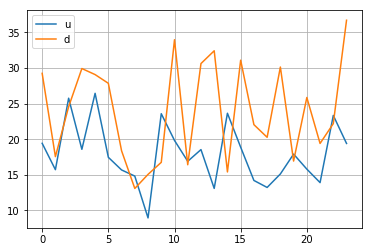

In [9]:
flxu_loss_h = LH.losses['flxu_loss'][1:-1].copy()
flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#dfdts_loss_h = LH.losses['dfdts_loss'].copy()*0
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
ax.plot(flxu_loss_h)
#ax.plot(dfdts_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['u','d', 'dtf']);

In [6]:
#M.load_weights('TrainedModels/20190528180258U')
M.load_weights('TrainedModels/20190603151941U_d')

In [10]:
print(np.mean(abs(M.get_weights()[-1][:,:,1])))
print(np.mean(abs(M.get_weights()[-1][:,:,0])))

0.03668557
0.10039887


IndexError: index 2 is out of bounds for axis 2 with size 2

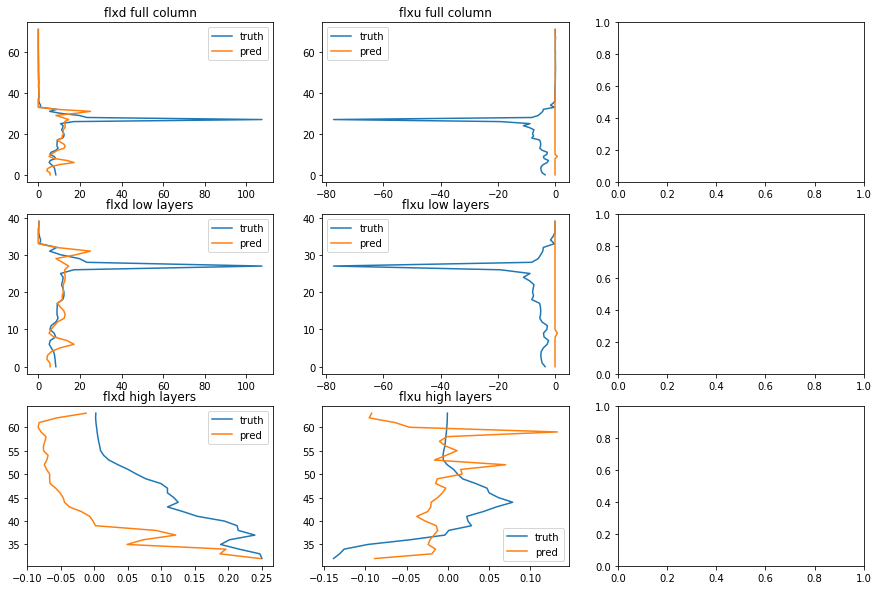

<Figure size 1080x576 with 0 Axes>

In [11]:
from utils import Plot_triple_diff_separated, F_and_plots
x,y = validation_generator[validation_generator.batch_per_file*2]
#x*=0
y0 = M.predict(x)
Plot_triple_diff_separated(F_and_plots(shape=(3,3)), y, y0, header_y, 32,j=-2)

In [14]:
M_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Origin_Input (InputLayer)       (None, 72, 8)        0                                            
__________________________________________________________________________________________________
Conv_0 (Conv1D)                 (None, 72, 64)       5120        Origin_Input[0][0]               
__________________________________________________________________________________________________
elu_0 (ELU)                     (None, 72, 64)       0           Conv_0[0][0]                     
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 72, 128)      81920       elu_0[0][0]                      
__________________________________________________________________________________________________
elu_1 (ELU

In [14]:
y0 = M.predict(x)
K.get_value(Up_Down_loss(y,y0))

array([119.180626 , 236.4114   ,  36.315987 ,  40.267593 ,  42.4373   ,
        52.550808 ,  49.377525 ,  42.611523 ,  98.097115 ,  17.423136 ,
        41.597565 ,  27.035698 ,  33.911007 ,  55.856567 , 179.30684  ,
        64.71829  , 125.39292  ,  32.41903  ,  89.467514 ,  87.2052   ,
        87.03991  ,  35.551903 ,  30.753212 ,  59.66852  ,  27.005178 ,
       127.81442  ,  39.377323 ,  51.005943 ,  69.139496 , 175.55186  ,
       106.4295   ,  73.37279  ,  84.65048  ,  21.824537 , 162.32712  ,
       118.78401  ,  38.29007  ,  29.069258 ,  67.714355 ,  33.370277 ,
        10.2811985,  89.20366  ,  77.36703  ,  42.07334  , 151.89763  ,
       259.94537  , 179.5668   ,  35.9371   , 156.10587  ,   2.523921 ,
        45.535675 ,  52.144276 ,  89.72643  ,  42.395947 ,  14.271667 ,
        99.45003  ,  26.534725 ,  20.169449 , 176.51404  ,  54.680077 ,
       133.73114  ,  24.309242 , 244.67969  , 201.63367  ], dtype=float32)

In [60]:
# CHECKING IMPACT OF LOWER LAYER
validation_generator.batch_size =512
x,y = validation_generator[0]

#o =M.layers[2].get_layer('dense_1').output
i = M_bd_cas.get_input_at(0)
#i  = M.layers[1].get_input_at(1)
o = M_bd_cas.get_output_at(0)
First_model = K.function([i],[o])

i0 = M_Up.get_input_at(0)
o0 = M_Up.get_output_at(0)
#
i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)
#
o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('Conv2_3').get_output_at(0)

Up_model = K.function( [i0],[o0])
Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])

#img = Dense_layer(First_model([x]))[0]

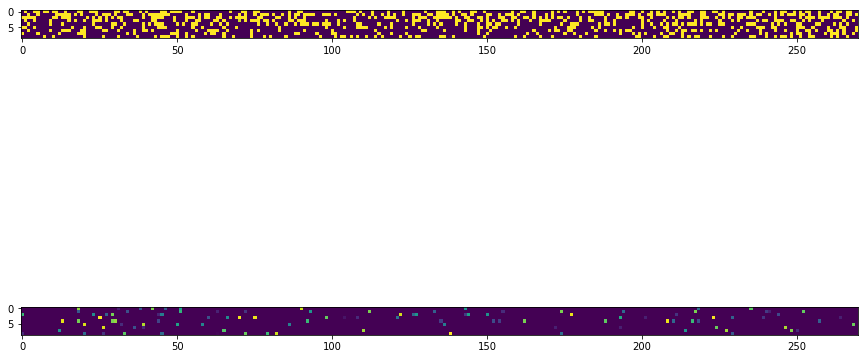

In [63]:
img = Dense_layer(First_model(Up_model([x])))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(211)
ax.imshow(img[1])
ax = f.add_subplot(212)
ax.imshow(np.std(img, axis=0))
#ax.imshow(np.mean(img,axis=0))

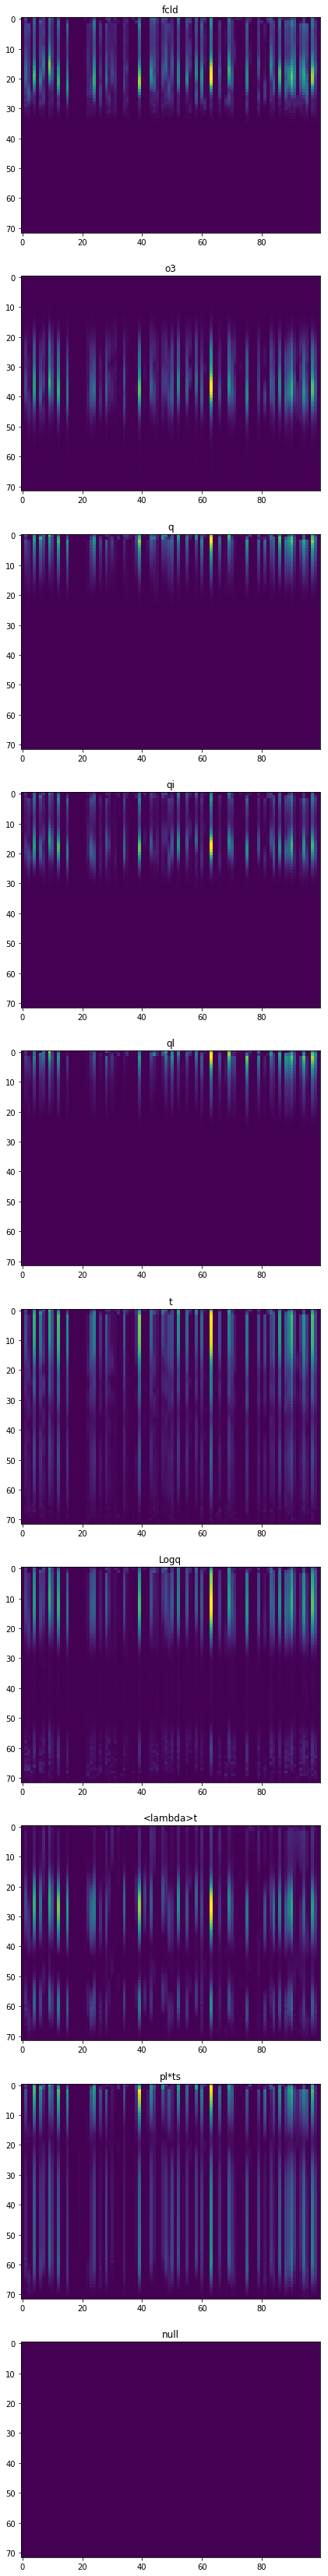

In [87]:
from utils import F_and_plots
x, y = validation_generator[400]
#X=[x.copy()]
X=[]
for i in range(len(header_x)):
    X.append(x.copy())
    X[i] *= 0
    X[i][:,:,i] = x[:,:,i]
X.append(x.copy()*0)

#    if(i==3):
#        X[i][:,:41, 3]=0

layer_output = [ First_model(Up_model([xi])) for xi in X ]
F = F_and_plots(shape=(len(header_x)+1,1), figsize=(20, 60))
for i in range(len(header_x)+1):    
    img = np.flip(np.mean(abs(layer_output[i][0] - layer_output[-1][0]), axis=0))
    if i==len(header_x):
        F[i].set_title('null')
    else:
        F[i].set_title(header_x[i])
    F[i].imshow(img)
    

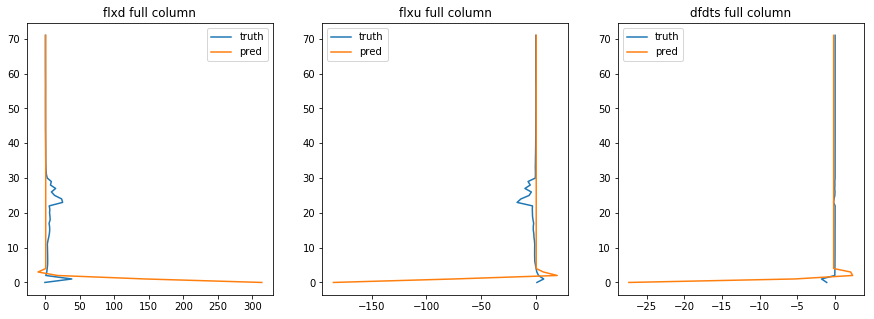

<Figure size 1080x576 with 0 Axes>

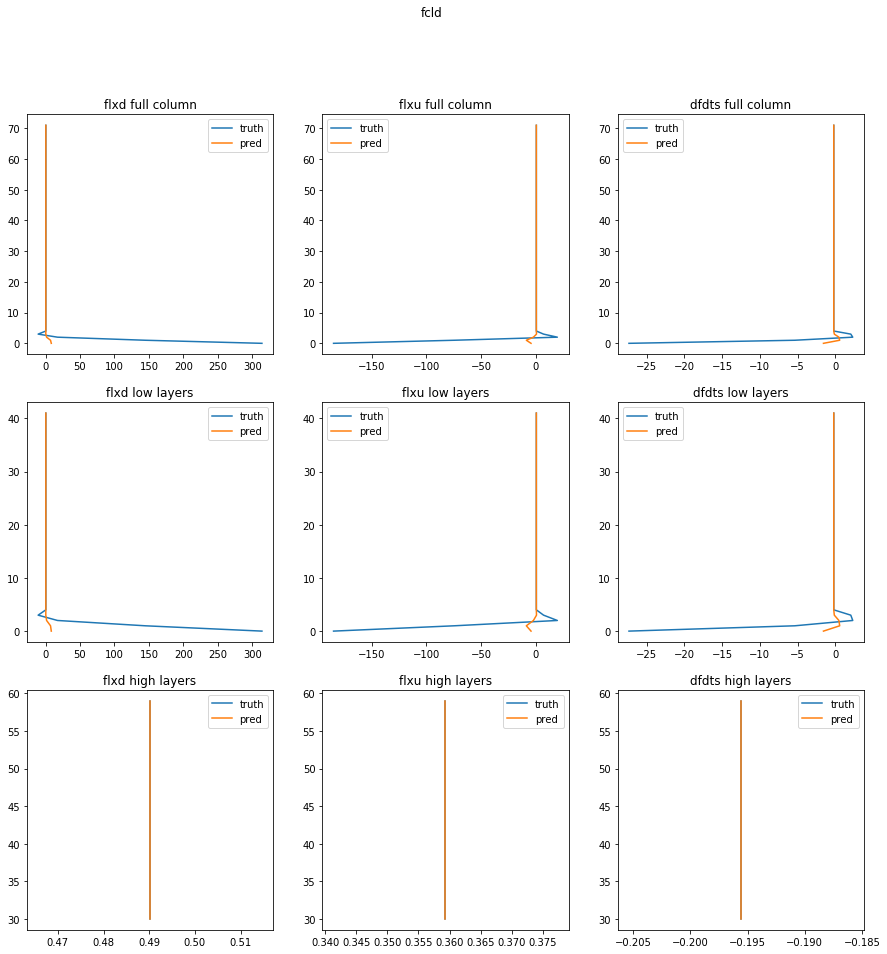

<Figure size 1080x576 with 0 Axes>

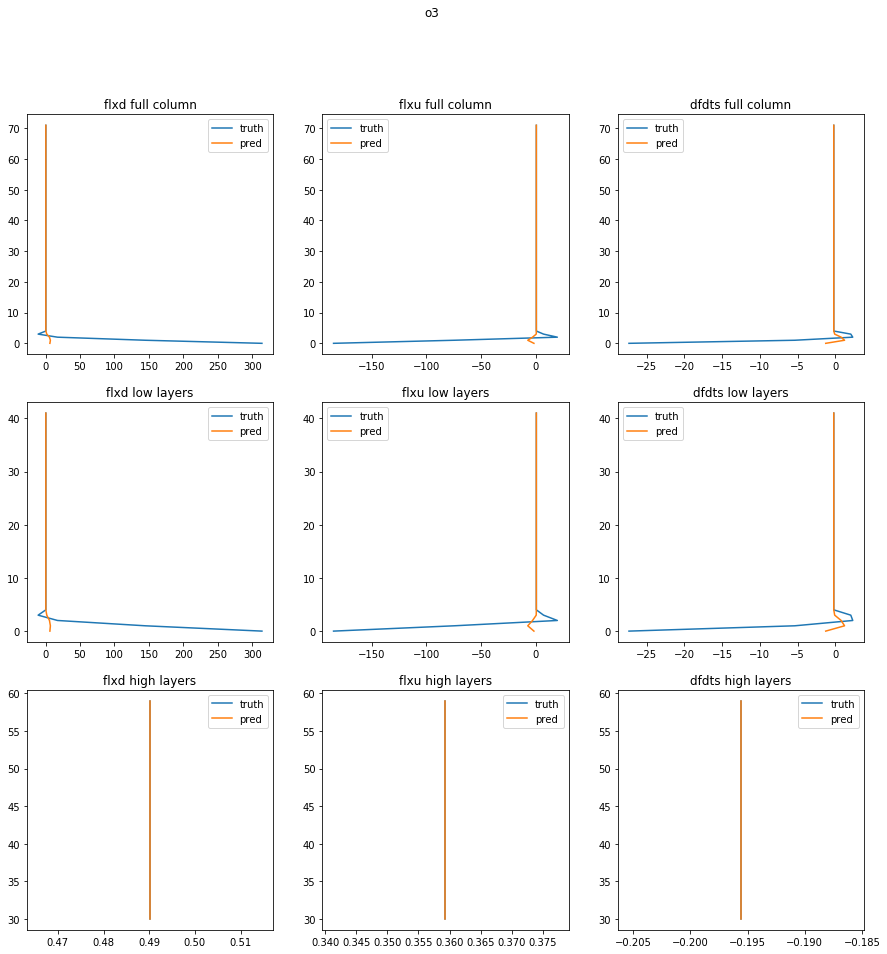

<Figure size 1080x576 with 0 Axes>

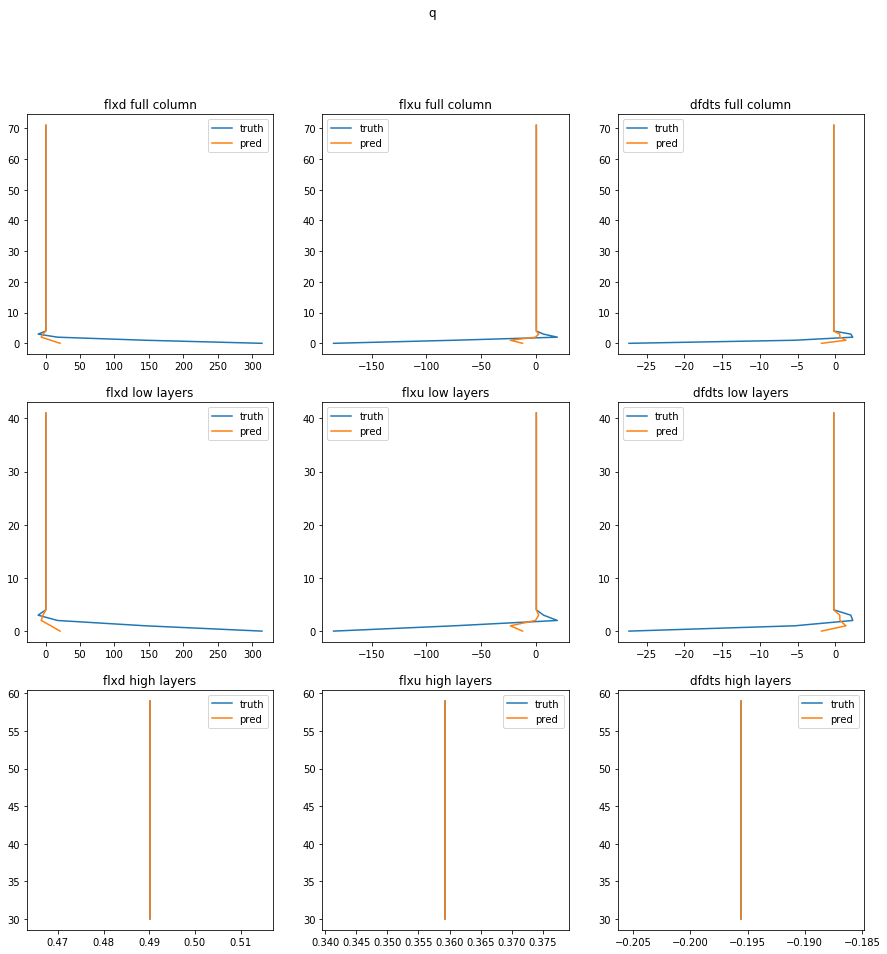

<Figure size 1080x576 with 0 Axes>

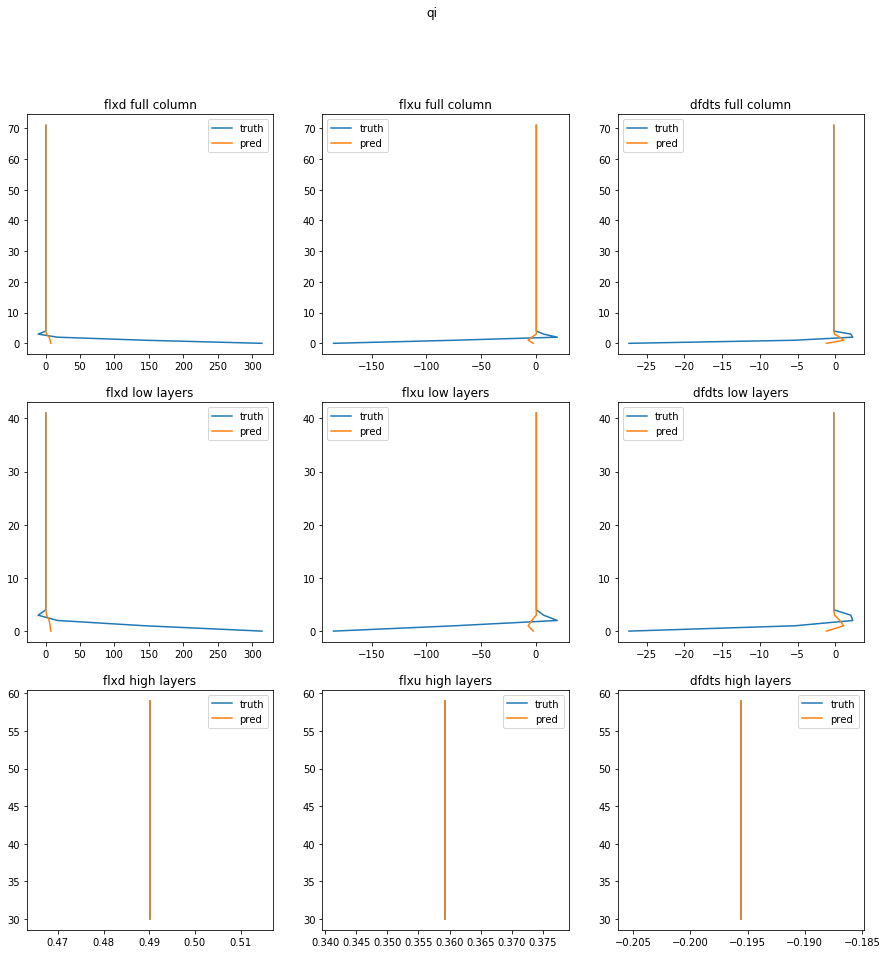

<Figure size 1080x576 with 0 Axes>

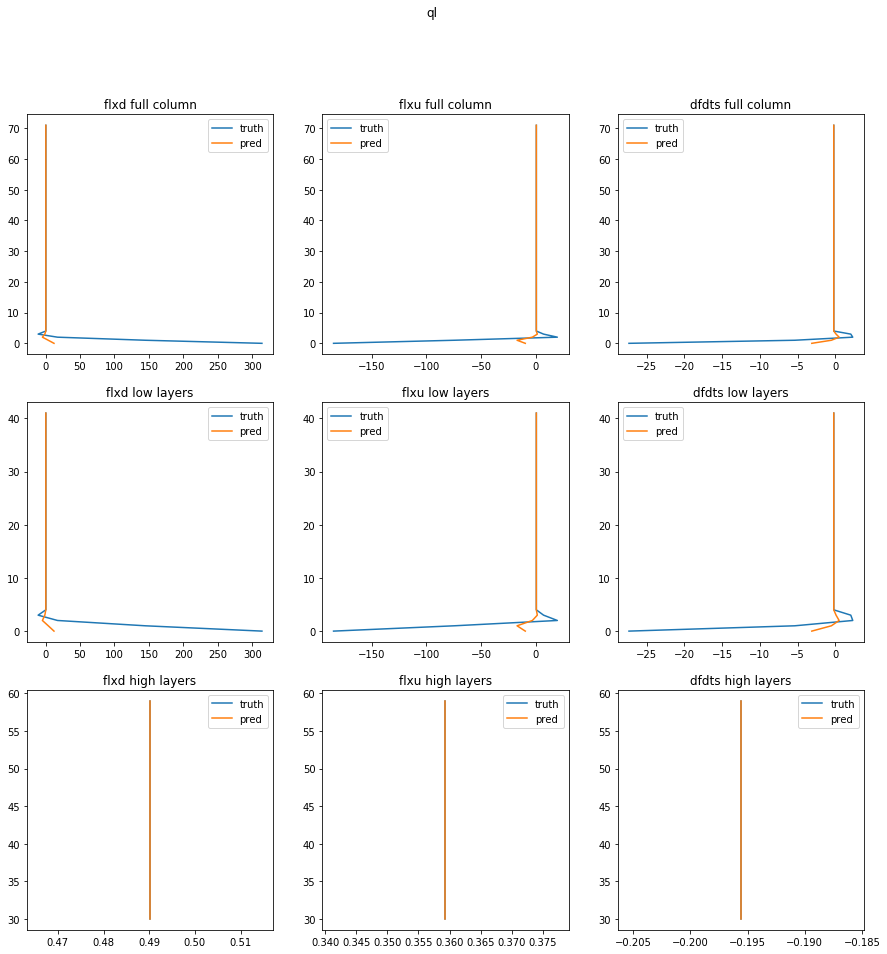

<Figure size 1080x576 with 0 Axes>

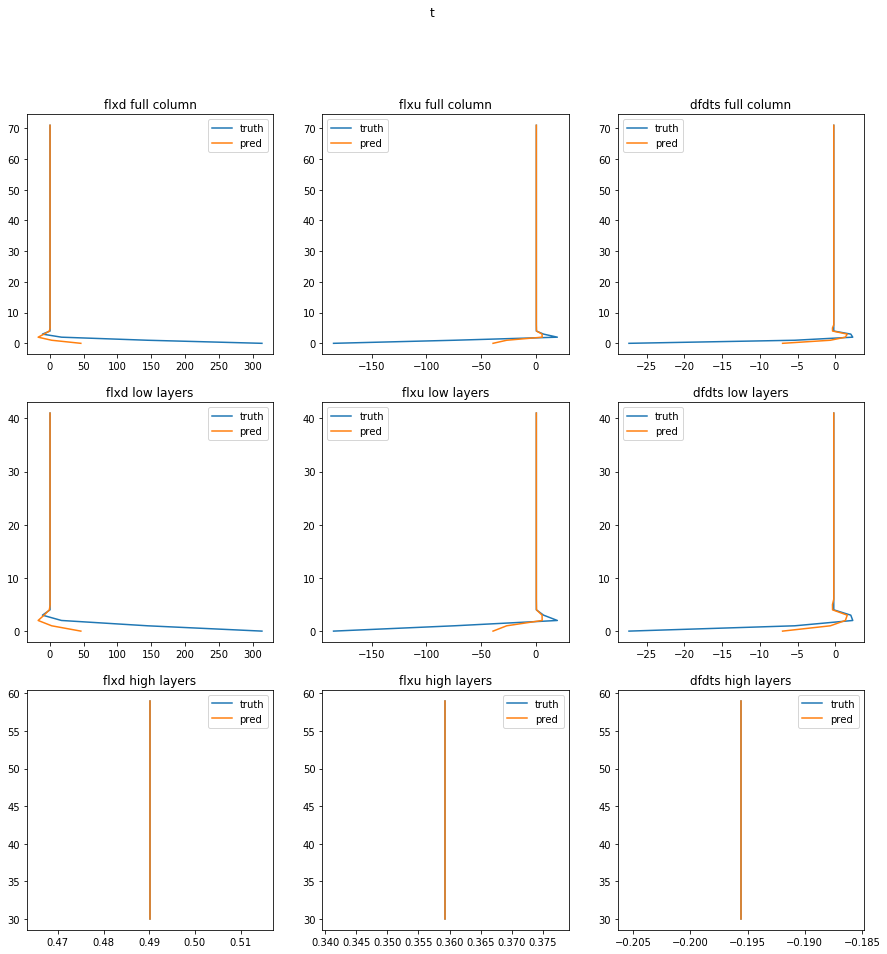

<Figure size 1080x576 with 0 Axes>

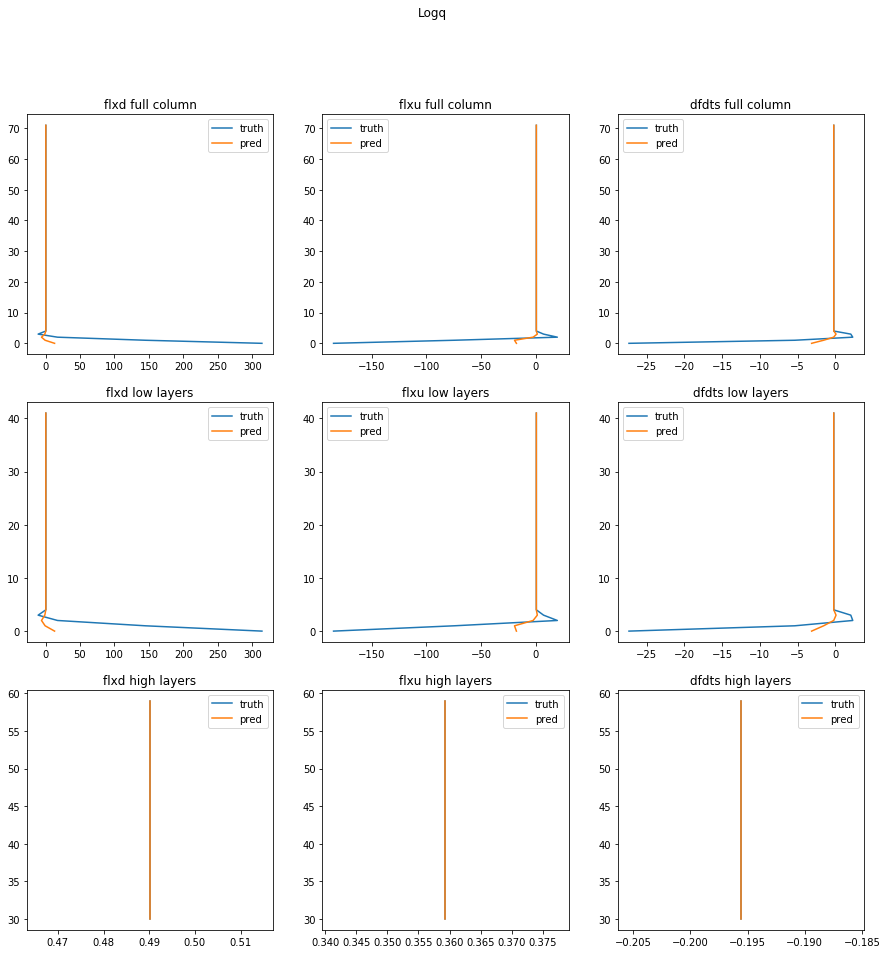

<Figure size 1080x576 with 0 Axes>

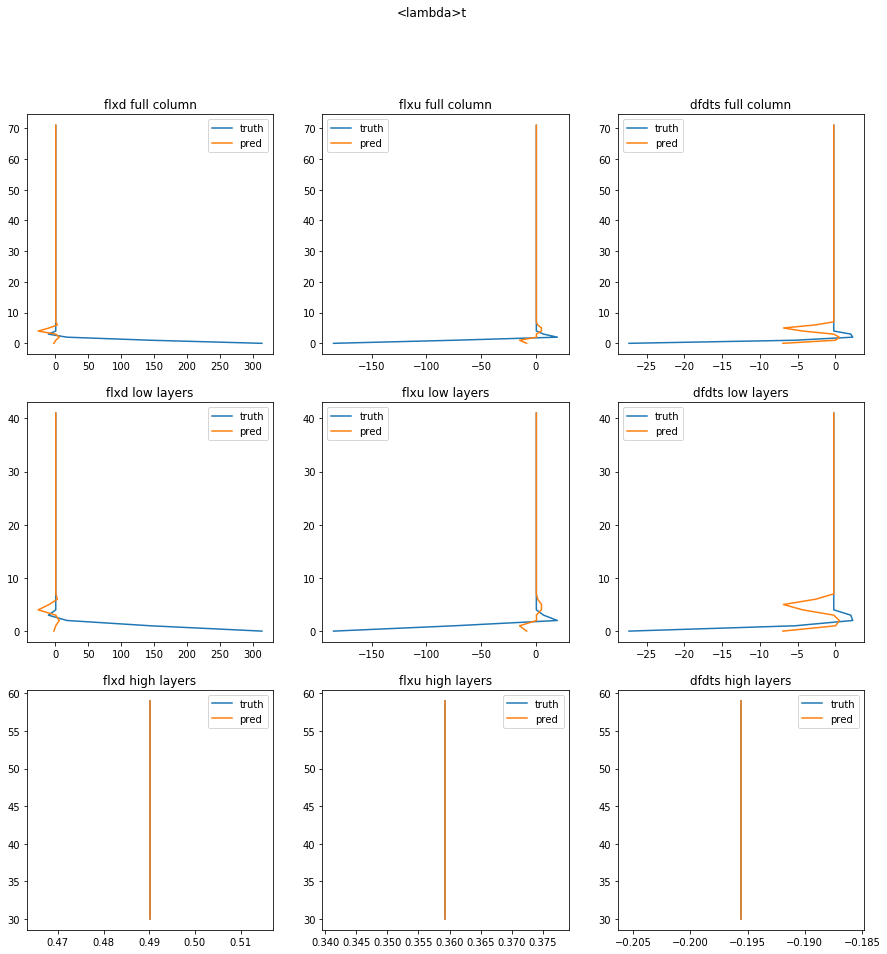

<Figure size 1080x576 with 0 Axes>

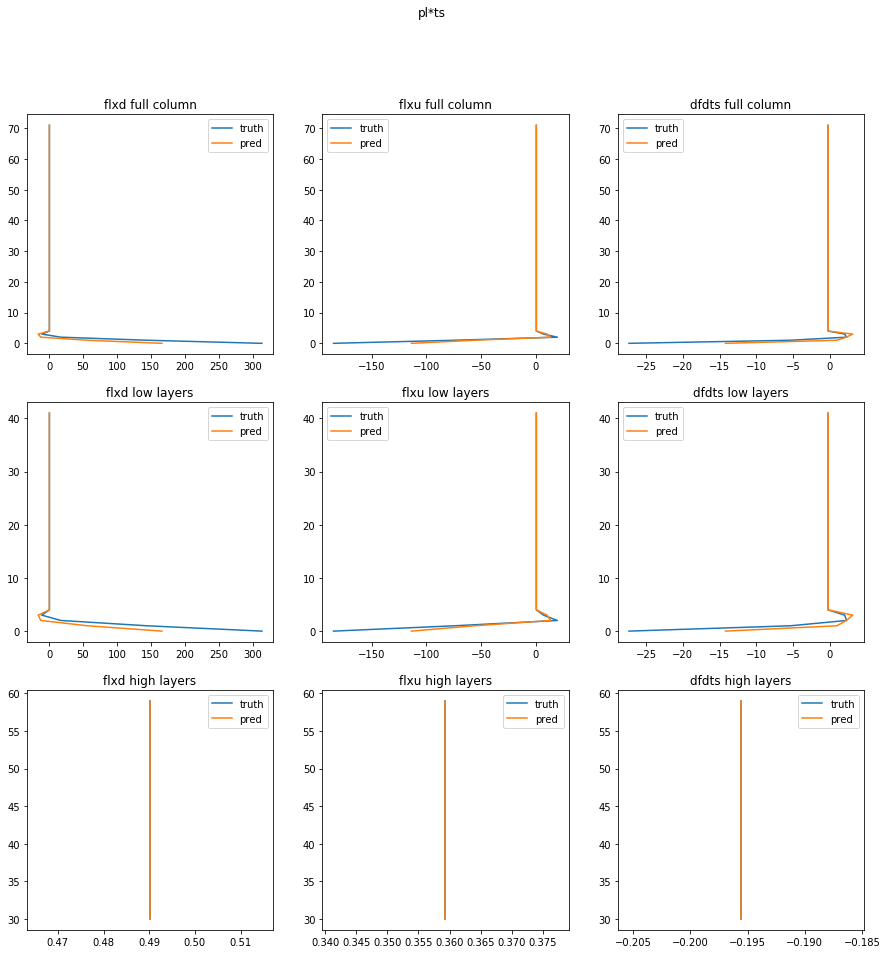

<Figure size 1080x576 with 0 Axes>

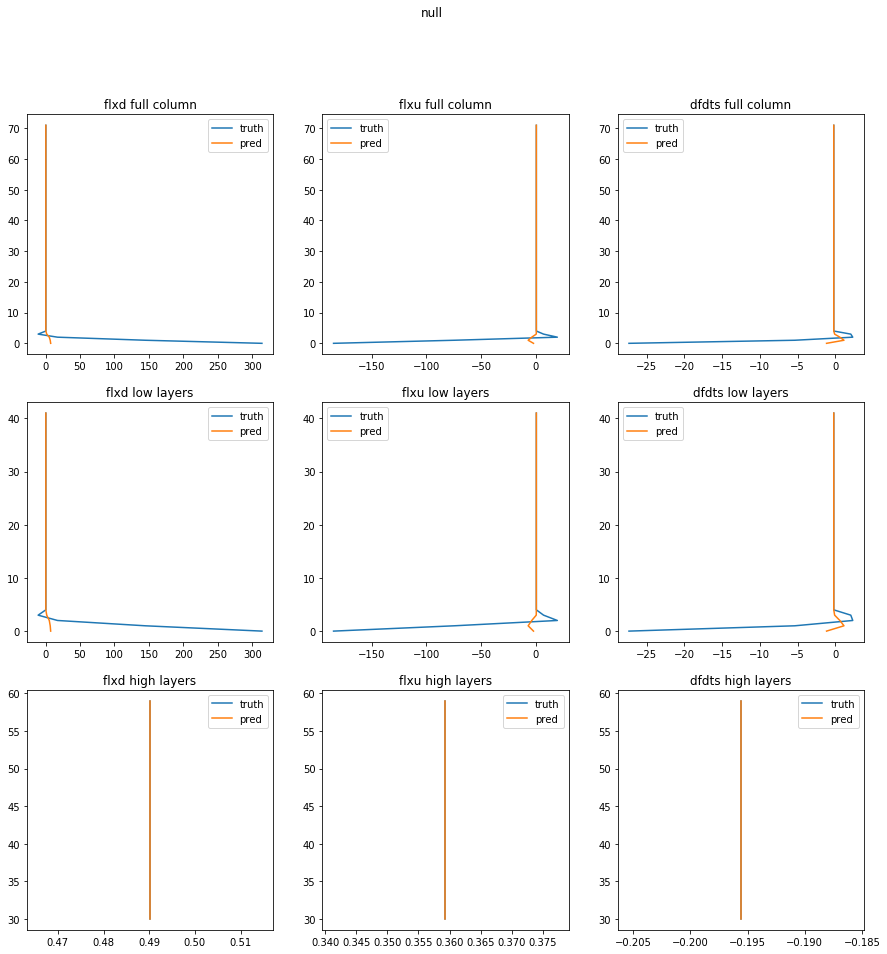

<Figure size 1080x576 with 0 Axes>

In [69]:
from utils import Plot_triple_diff_separated
x,y = validation_generator[500]
y1 = M.predict(x)
y_pred = [M.predict(xi) for xi in X]

F = F_and_plots(shape=(1,3), figsize=(15,5))
Plot_triple_diff_separated(F,y, y1, header_y)
for i,y0 in enumerate(y_pred):
    F = F_and_plots(shape=(3,3), figsize=(15,15))
    if i==len(header_x):
        F.f.suptitle('null')
    else:
        F.f.suptitle(header_x[i])
    Plot_triple_diff_separated(F,y1, y0, header_y, sep=30)

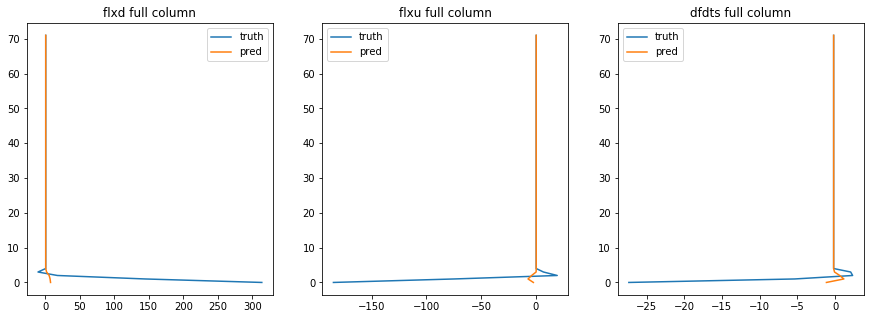

<Figure size 1080x576 with 0 Axes>

In [70]:
F = F_and_plots(shape=(1,3), figsize=(15,5))
Plot_triple_diff_separated(F,y1, y0, header_y);

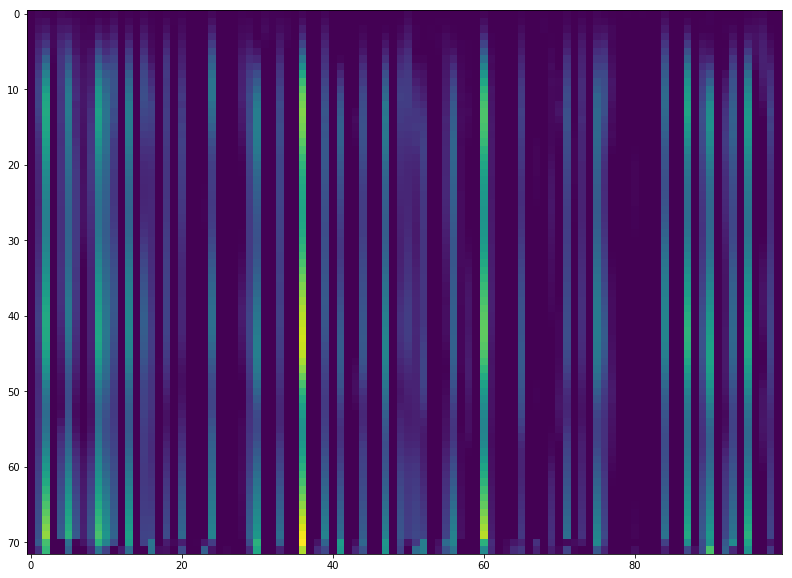

In [71]:
img = First_model(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.mean(img, axis=0))

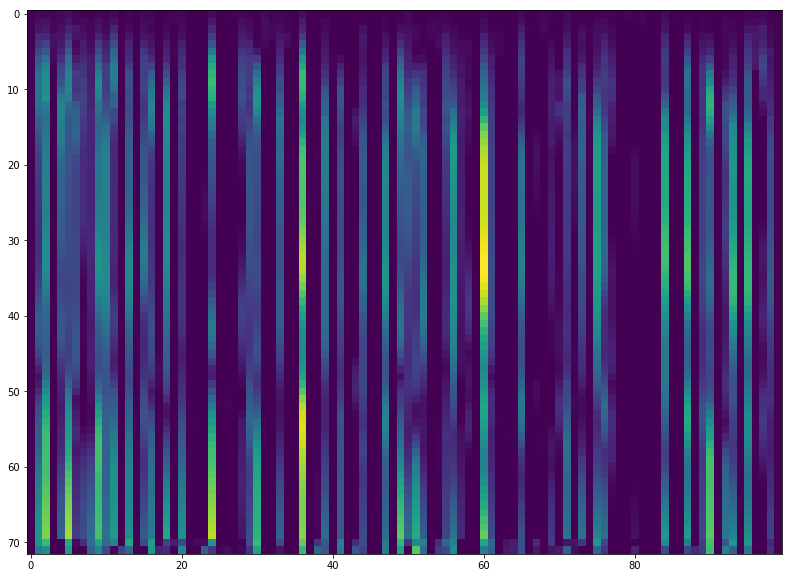

In [82]:
img = First_model(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow(np.std(img, axis=0))

In [85]:
np.max(img)

56.920013

In [85]:
set0=False
x,y = validation_generator[validation_generator.batch_per_file*3+1]

if set0 :
    W = M_unet.get_layer('dense_1').get_weights()
M_unet.get_layer('dense_1').set_weights([W[0]*0, W[1]*0])
y0 = M.predict(x)
M_unet.get_layer('dense_1').set_weights([W[0], W[1]])
y1 = M.predict(x)

## TRAINING ON THE POLE :

In [109]:
train_generator.List_of_dir

['Data2/20190401_0400z', 'Data2/20190401_0400z_antartica']

In [120]:
print(train_generator.idx_folder)
print(train_generator.idx_file)
train_generator.idx_folder = [1]
train_generator.idx_file = [5*i+4 for i in range(5)]
train_generator.max_b = train_generator.batch_per_file*5

[1]
[4, 9, 14, 19, 24]


In [121]:
len(train_generator)

9720

In [124]:
K.set_value(Adam.iterations, len(train_generator))

In [125]:
history = M.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                             shuffle=False,
                               callbacks = [LH],
                               epochs=1,
                               verbose=1)

Epoch 1/1
9720/9720 [==============================] - 588s 60ms/step - loss: 16146.8004 - flxd_loss: 48.7103 - flxu_loss: 14.4843 - dfdts_loss: 15939.7536 - val_loss: 88.7931 - val_flxd_loss: 37.0277 - val_flxu_loss: 15.2483 - val_dfdts_loss: 26.1284


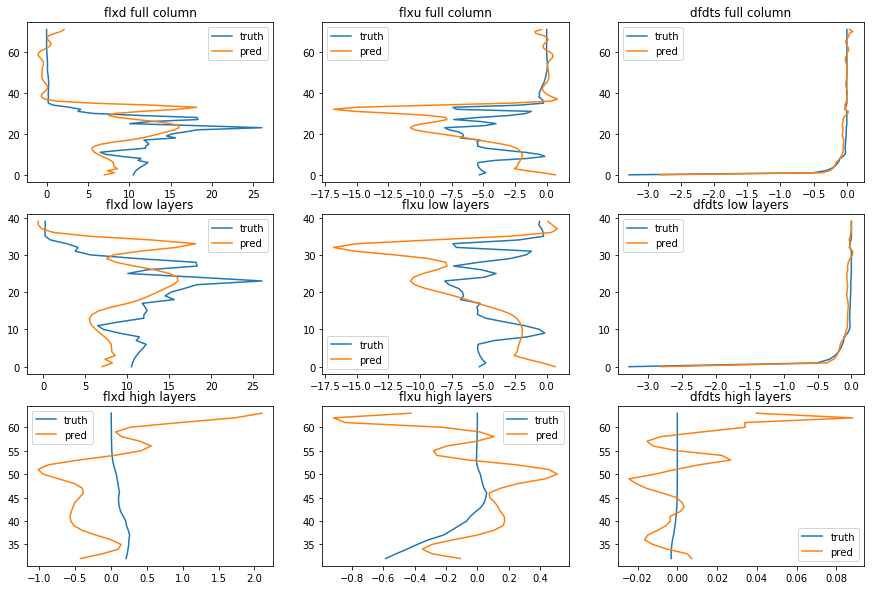

<Figure size 1080x576 with 0 Axes>

In [126]:
from utils import Plot_triple_diff_separated, F_and_plots
x,y = validation_generator[validation_generator.batch_per_file*3+1]
#x*=0
y0 = M.predict(x)
Plot_triple_diff_separated(F_and_plots(shape=(3,3)), y, y0, header_y, 32)

In [43]:
np.max(l[0])

47052

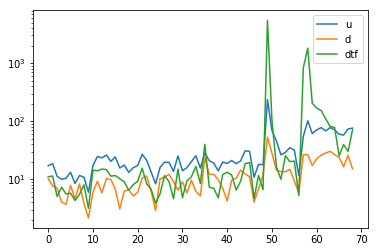

In [32]:
flxu_loss_h = [10.182575995048868, 7.658432195216049, 7.026470168627829, 4.008050361287937, 3.7040922690811473, 7.837056729038066, 4.602975099665638, 8.313896022215792, 3.8213169427565585, 2.15045567893197, 5.931576324588478, 9.224523976015947, 5.811866038130144, 10.196603531700102, 9.89281523276749, 6.727811334555041, 3.070992175443673, 6.24595861866641, 6.557454427083333, 5.142278726208848, 5.903511706693672, 10.507620603459362, 11.317640014146091, 6.258006405928498, 2.881825639387217, 10.15504838605967, 10.904882611561215, 12.105907801247428, 9.050905832047325, 6.422087995113169, 9.01927605774177, 5.792040412808642, 9.61083682966821, 6.199771331661522, 5.143458739229681, 23.149225180041153, 12.082431118184155, 12.157802252121913, 9.795231320730453, 6.940095626768262, 4.202838411056455, 9.643042293595679, 10.42674073270319, 14.273290814686215, 12.320910292888374, 11.046465084876543, 4.022486306021734, 6.867738072273663, 11.724536032343106, 53.07089522247942, 27.917673369984566, 14.326857076260287, 13.470870908886317, 13.480149257330247, 14.78540641878858, 9.252386148083847, 5.802669572241513, 26.317933384773664, 26.5937901877572, 17.141716097608025, 22.57586041988169, 26.00151708783436, 28.361191486625515, 30.276435506687243, 26.537004886831276, 23.820975597993826, 16.39551283596965, 25.777267393261315, 15.083226835776749]
flxd_loss_h = [17.026447563014404, 18.53932974858539, 11.17751736111111, 9.971129115226338, 10.393971635480968, 13.162299262152779, 8.413520969971708, 11.582643108603396, 10.813160083912036, 5.950265138728138, 17.1680089377572, 24.60099987139918, 23.31715374228395, 26.065098138503085, 20.325842335390945, 24.175481851208847, 15.610228989840534, 17.493324813528808, 13.116081331983025, 15.766004774305555, 17.258879484953702, 26.854267136059672, 21.214564445087447, 13.315414617091049, 8.335853105709877, 15.922541112075617, 19.591668274176953, 19.472808963477366, 13.632301110789609, 25.196439766589506, 14.029151194380145, 15.829223130465534, 20.09644659850823, 25.385933079346707, 15.590655542695472, 28.262289416152264, 20.83152689364712, 18.92109535751029, 13.914633166152264, 19.735196839634774, 18.68356159979424, 21.05126551247428, 18.486892762988685, 20.67670355902778, 30.803142280735596, 30.21318198623971, 10.782075858410494, 17.995736078960906, 17.81735869984568, 234.23709169238683, 68.84750353652264, 45.695404931841566, 26.306749131944443, 28.975487477494855, 34.947450488683124, 31.621706613297324, 11.608687789351851, 54.70798369984568, 101.66120113168725, 61.203032568158434, 70.86280703446502, 77.49949363425925, 67.93733121141975, 77.50051440329219, 70.57152617026749, 59.764359085648145, 57.66683947402263, 73.24396379886831, 76.04018775720165]
dfdts_loss_h = [10.998784320344651, 11.374769925090021, 5.023108965084877, 7.2669039753729425, 5.56689654063786, 5.73045970775463, 4.308012032214506, 5.478708526234568, 8.00853587962963, 3.1496373557259516, 14.30347583912037, 13.978491512345679, 14.954811881108538, 14.636160140174898, 11.320879147376543, 11.542900430812757, 10.191769949202675, 8.99561149691358, 6.45435976884002, 8.046754436728396, 9.178772223829732, 15.432885440779321, 8.319918659979423, 6.727030185024434, 3.8488965446566357, 5.6275197723765435, 11.545875329539609, 9.100441261574074, 4.617855119116513, 14.926563906571502, 4.7921926239390435, 9.351351514274691, 10.991118505658436, 16.66398815264918, 8.41502298739712, 39.99355388374486, 7.283361866640947, 6.959469139821245, 4.771930459104938, 12.019961259002057, 13.177666055812757, 11.80002270608282, 6.483045789930555, 9.258630320859053, 18.441243489583332, 19.45037213863169, 4.68150549366641, 11.622251157407407, 6.592103306648663, 5495.3215020576135, 101.99473540380659, 16.26199705021862, 9.96261835294496, 25.359535751028808, 20.084914721579217, 20.471743987911523, 5.1939928345228905, 829.227109053498, 1812.5558127572017, 203.87149562757202, 168.5669045781893, 152.3521412037037, 110.11967110339506, 81.08824427726337, 77.86976755401234, 25.306071968235596, 39.458574459876544, 30.236135223765434, 70.97834683641975]
loss_h  = [38.20778677983539, 37.57253890174897, 23.227121109825102, 21.246065618569958, 19.66498681841564, 26.729775511188272, 17.32450810185185, 25.37526523919753, 22.643018180941358, 11.250356666345164, 37.40305909207819, 47.804032439557616, 44.08381558641975, 50.89774225180041, 41.53954877186214, 42.44617251800412, 28.872958461934157, 32.73490547839506, 26.12785534014918, 28.95507008744856, 32.34115186149691, 52.79479327417695, 40.85204877186214, 26.300475823045268, 15.066574033886317, 31.7051183127572, 42.04243827160494, 40.67915702160494, 27.30103242348251, 46.54509066358025, 27.840615354938272, 30.97263213734568, 40.698419013631685, 48.24976691100823, 29.149108635545268, 91.40514885545268, 40.19732992541152, 38.03834715792181, 28.481788917824073, 38.69523614326132, 36.06409947273662, 42.494357638888886, 35.396629050925924, 44.20859455375514, 61.56528099279836, 60.70999710648148, 19.486064895190328, 36.4857092335391, 36.13399000128601, 5782.648148148148, 198.76019161522635, 76.28420781893004, 49.740290637860085, 67.81508809156378, 69.81776459619341, 61.34581163194444, 22.605324074074073, 910.2536008230453, 1940.8092849794239, 282.21611368312756, 262.0057388117284, 255.85323431069958, 206.4180652006173, 188.86521026234567, 174.97829861111111, 108.89133230452676, 113.52093782150206, 129.25737847222223, 162.1019000771605]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
ax.plot(flxu_loss_h)
ax.plot(dfdts_loss_h)
#ax.plot(loss)
ax.set_yscale('log')
ax.legend(['u','d', 'dtf']);

In [ ]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
            
Klist0 = [ FKernel(Log, ['q'], 1)]
Klist = []
Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression([pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)

D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
D2[0]['t'].fit(fit_genator[0][0][:,:,9])
D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)
del(normal_generator)


##### Full Preprocessing :
FP = Klist0 + D + Klist + D2  + D3 + V 

##### b_size
batch_size= 64


train_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)
validation_generator = Up_and_Down_Generator(folder='Data', batch_size=batch_size, train=False, preprocess_x=FP, shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [4]:
# Set Cold generator
cold_generator.List_of_dir=['Data2/20190401_0400z_antartica/']
cold_generator._div = 5
cold_generator.idx_file = [4,9,14,19,23]
# Set "normal generator"
train_generator.idx_file = np.arange(25)
j=25
for i in range(25):
    if(i%5==4):
        if(i<j):
            j=j-1
            if(j%5==4):
                j-=1     
            a,b = train_generator.idx_file[i], train_generator.idx_file[j]
            train_generator.idx_file[j] = a
            train_generator.idx_file[i] = b
train_generator._div = 20            
train_generator.idx_file = train_generator.idx_file[:20]
print(train_generator.idx_file)
print(cold_generator.idx_file)

NameError: name 'cold_generator' is not defined